In [14]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda,UpSampling2D, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam,RMSprop
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil
import pandas as pd
tf.keras.backend.clear_session()

#### <font color="red">1. Load dataset</font>

Load NumPy arrays with tf.data.Dataset. Passing the two arrays as a tuple into tf.data.Dataset.from_tensor_slices to create a tf.data.Dataset.


In [15]:
specific_directory1 = '/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked'
specific_directory2 = '/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked'
specific_directory3 = '/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked'
specific_directory4 = '/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked'

path_train ='/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked/train'
path_test ='/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked/test'
path_val= '/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked/valid'

nbatch = 10

def dataset_array(flow_path,geo_path):
    def load_array(flow,geo):
        x = np.load(flow)
        y = np.load(geo)
        return x,y

    x, y = tf.numpy_function(load_array, [flow_path, geo_path], [tf.float64, tf.float64])
    x.set_shape([x.shape[0],x.shape[1],x.shape[2]])
    y.set_shape([y.shape[0],y.shape[1],y.shape[2]])
    return x,y

def create_dataset(flow_path,geo_path,batch_size = nbatch):
    x_files = sorted(glob.glob(os.path.join(flow_path, "*.npy")))
    y_files = sorted(glob.glob(os.path.join(geo_path, "*.npy")))
    dataset = tf.data.Dataset.from_tensor_slices((x_files, y_files))
    dataset = dataset.map(dataset_array, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

    
    

Creating datasets

In [16]:
geo_path_train='/home/ppgi/Trabajo/predicting-flow-patterns/G_Masked/train'
p_path_train='/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked/train'

geo_path_valid='/home/ppgi/Trabajo/predicting-flow-patterns/G_Masked/valid'
p_path_valid='/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked/valid'

geo_path_test='/home/ppgi/Trabajo/predicting-flow-patterns/G_Masked/test'
p_path_test='/home/ppgi/Trabajo/predicting-flow-patterns/V_Masked/test'

train_ds =create_dataset(geo_path_train,p_path_train)
test_ds  =create_dataset(geo_path_test,p_path_test)
valid_ds =create_dataset(geo_path_valid,p_path_valid)

#### <font color="red">3. Hiperparameters</font>

In [17]:
num_epochs    =30
patience      =15       # How long to wait after last time validation loss improved
LR            =0.0001

# Model name
model_name    ="U-Net"
save_in       ='/home/ppgi/Trabajo/predicting-flow-patterns'

# image dimensions
img_width     =  256   # 739   G:737
img_height    =  64   # 185
channel       =  1

#number_of_filters = [64, 128, 256, 512, 1024]
number_of_filters = [32,64,128,256,512]

type_padding = 'same'
f_activation = 'relu'
f_activation_last='relu'
#optimizer = RMSprop(learning_rate=LR)
optimizer = Adam(learning_rate=LR)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  min_delta=1e-2, patience=patience, restore_best_weights=True,verbose=1)
save = save_in + '/Results_weights/Best_weights.weights.h5'
checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(save,save_weights_only=True)


#### <font color="red">4. Architecture</font>

In [18]:
def conv_block_batchnorm(filters,x):
    conv = Conv2D(filters, (3, 3), padding=type_padding)(x)
    conv= BatchNormalization()(conv)
    conv = Activation(f_activation)(conv)
    conv = Conv2D(filters, (3, 3), padding=type_padding)(conv)
    conv= BatchNormalization()(conv)
    conv = Activation(f_activation)(conv)
    return conv
    
def conv_block(filters,x):
    conv = Conv2D(filters, (3, 3), activation=f_activation, padding=type_padding)(x)
    conv = Conv2D(filters, (3, 3), activation=f_activation, padding=type_padding)(conv)
    return conv    

def encoder(x,filters):
    conv = conv_block_batchnorm(filters,x)
    downsample = MaxPooling2D((2,2))(conv)
    return conv,downsample

def decoder(x1,x2,filters,transpose=None):
    if transpose != None:
        conv_up = Conv2DTranspose(filters,(2,2),strides=(2, 2),padding=type_padding)(x1)
    else:
        conv_up = UpSampling2D((2, 2))(x1)
   
    concat=concatenate([conv_up,x2],axis = 3)
    up = conv_block(filters, concat)
    return up



##### <font color="red">4.1 U-Net </font>
Building  u-net arquitecture with one decoder i.e. only pression as output

In [19]:
# number_of_filters = [32,64,128,256,512]
def make_model():
    
    image_input = Input((img_height, img_width, channel))
    
    conv1,down_block1 = encoder (image_input, number_of_filters[0])
    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])
    conv3,down_block3 = encoder (down_block2 , number_of_filters[2])
    conv4,down_block4 = encoder (down_block3 , number_of_filters[3])

    conv5 = conv_block(number_of_filters[4],down_block4)

    up6=decoder(conv5,conv4,number_of_filters[3],transpose='yes')
    up7=decoder(up6,conv3,number_of_filters[2],transpose='yes')
    up8=decoder(up7,conv2,number_of_filters[1],transpose='yes')
    up9=decoder(up8,conv1,number_of_filters[0],transpose='yes')

    p_out = Conv2D(1, (1, 1), activation=f_activation_last,name='p_output',padding="same")(up9)

    # construct model
    model =  keras.Model(inputs=image_input, outputs=[p_out],name= model_name)
    
    model.summary()

    model.compile(optimizer=optimizer, 
              loss = 'mean_squared_error',
              
              metrics= ['mae'] )

    return model  

In [20]:
M=make_model()
#tf.keras.utils.plot_model(M, show_shapes=True, expand_nested=True, dpi=64)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 256,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 256,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 256,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 256,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 256,   │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 256,   │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 256,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 128,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 128,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 128,   │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128,   │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,763,361 (29.61 MB)

 Trainable params: 7,761,441 (29.61 MB)

 Non-trainable params: 1,920 (7.50 KB)


##### <font color="red">4.2 Fitting</font>

In [21]:
print("Starting trainig")

history = M.fit(train_ds,epochs=num_epochs,validation_data = valid_ds,callbacks=[early_stopping,checkpoint_cb])
callbacks = [tf.keras.callbacks.ModelCheckpoint("Unet.keras",save_best_only=True)]
M.save('Completed_Model.h5')

Starting trainig
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - loss: 0.0223 - mae: 0.0775 - val_loss: 0.0170 - val_mae: 0.1047
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0017 - mae: 0.0218 - val_loss: 0.0117 - val_mae: 0.0831
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0013 - mae: 0.0154 - val_loss: 0.0139 - val_mae: 0.0934
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0012 - mae: 0.0132 - val_loss: 0.0168 - val_mae: 0.1094
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0011 - mae: 0.0120 - val_loss: 0.0145 - val_mae: 0.1050
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0011 - mae: 0.0114 - val_loss: 0.0094 - val_mae: 0.0853
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0010 - mae: 0.0110 - val_loss: 0.0048 - val_mae: 0.0596
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0010 - mae: 0.0107 - val_loss: 0.0026 - val_mae: 0.0417
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 

##### <font color="red">4.3 Evaluation</font>

In [22]:
results = M.evaluate(test_ds) 
print("Evaluation results:")
for name, value in zip(M.metrics_names, results):
    print(f"{name}: {value:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047 - mae: 0.0592
Evaluation results:
loss: 0.0047
compile_metrics: 0.0594


##### <font color="red">4.4 Prediction</font>

In [23]:
xtrue=[]
ytrue=[]
for x,y in test_ds:
    xtrue.append(x.numpy())
    ytrue.append(y.numpy())

ypred = list()
for i in range(nbatch):
        ypred.append(M.predict(xtrue[i]))


2025-05-23 17:44:34.981583: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


##### <font color="red">4.5 Visualization of flow predicted</font>

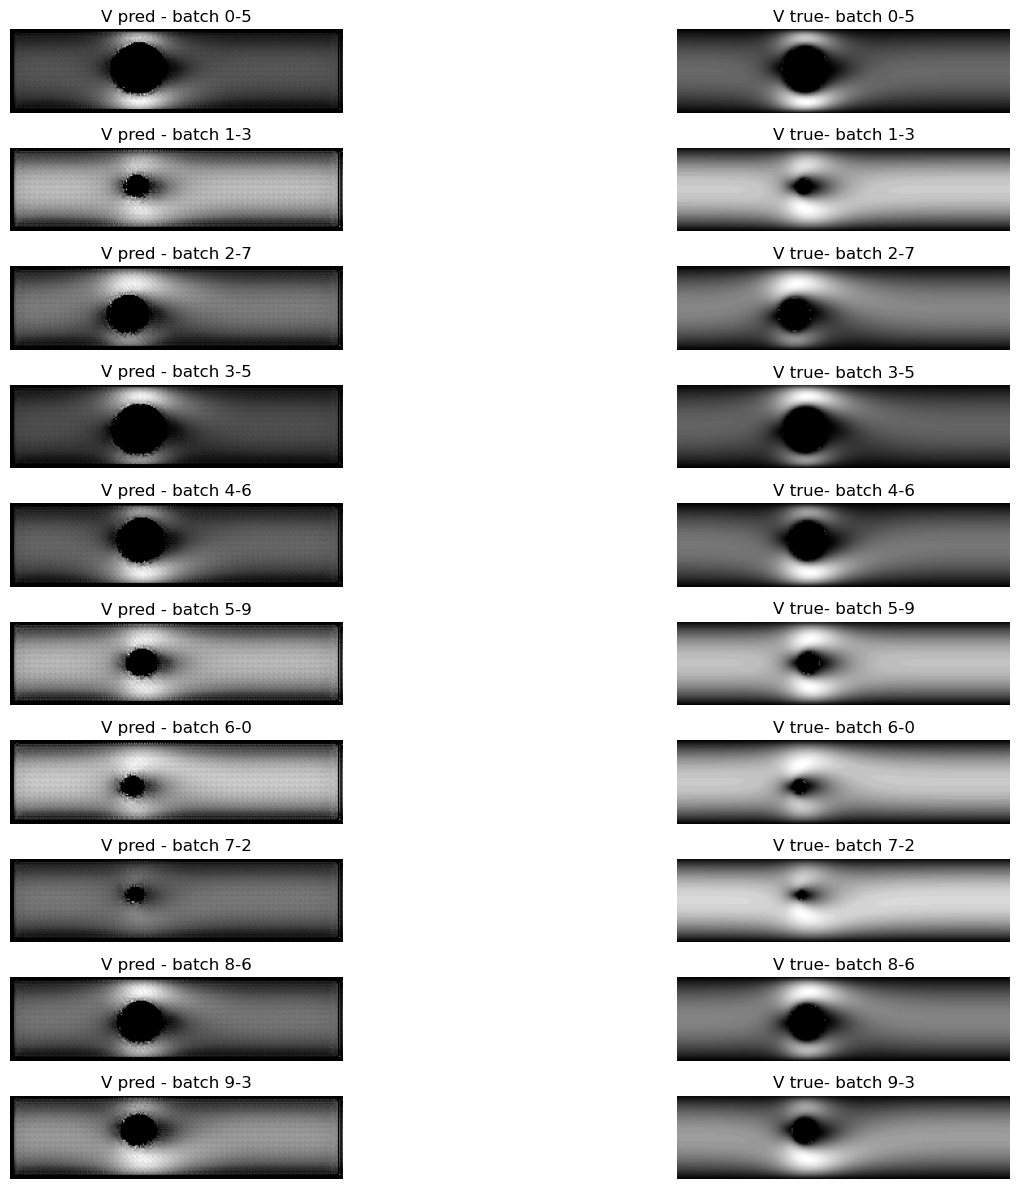

In [24]:
fig, axes = plt.subplots(10, 2, figsize=(16, 12))
titles = [ 'P pred', 'P true','V pred', 'V true','Vx pred', 'Vx true','Vy pred', 'Vy true']
for i in range(nbatch):
    N = random.randint(0, nbatch-1)
    title = titles[2:4]
    axes[i, 0].imshow(ypred[i][N], cmap='gray'); axes[i, 0].set_title(f'{title[0]} - batch {i}-{N}')
    axes[i, 1].imshow(ytrue[i][N], cmap='gray'); axes[i, 1].set_title(f'{title[1]}- batch {i}-{N}')

for ax in axes.flat:
    ax.axis('off')    

plt.tight_layout()
plt.show()     

##### <font color="red">4.6 Training and Validation plots</font>

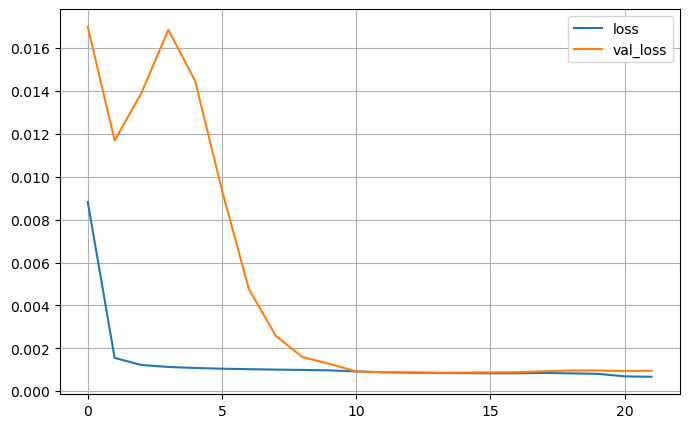

In [25]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.show()


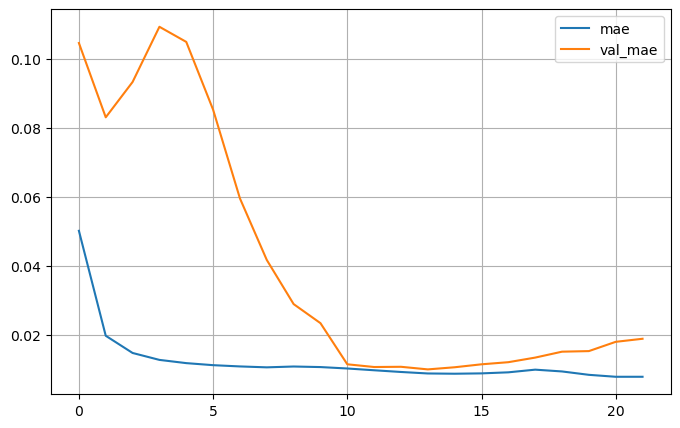

In [26]:
pd.DataFrame(history.history)[['mae', 'val_mae']].plot(figsize=(8, 5))
plt.grid(True)
plt.show()  
fig.savefig("Output V.png", dpi=300, bbox_inches='tight')    